## Init SAC

The _Soft Actor Critic_ (SAC) algorithm is an off-policy algorithm similar to DDPG and TD3, that
learns a stochastic policy instead. It adopts many of the techniques used in TD3, but it stems from
the _Maximum Entropy Formulation_ of reinforcement learning.

For an in-depth understanding of both max-ent and SAC, I suggest watching
[Lecture 1](https://www.youtube.com/watch?v=2GwBez0D20A&list=PLwRJQ4m4UJjNymuBM9RdmB3Z9N5-0IlY0&index=2)
of Peter Abbeel Deep RL course, and reading the OpenAI SpinningUp SAC summary.

In short and as a highlight, in this formulation of RL the optimization objective is to maximize the
expected return plus the _entropy_ of the policy $H[ \pi (a | s_t)]$, term that intuitively balance
exploration and exploitation:

$$
\max_{\pi} \mathbb{E}\Bigl[ \sum_{t=0}^{T} r_t + \beta H[ \pi (a | s_t)] \Bigr]
$$

The _entropy_ in fact "measures" how uncertain is a policy (i.e., a deterministic policy has a very
low entropy, while a random one has high entropy).

While the _critic_ network learns the action-value as usual, the _actor_ network learns the mean
and standard deviation of a Gaussian representing the stochastic policy, using `tanh` to "squash"
the values in an acceptable range, and having the `logstd` depending on the network parameters as
well.

In [ ]:
%pip install stable-baselines3 numpy torch supersuit pettingzoo pymunk scipy gymnasium

import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from stable_baselines3 import SAC

from __future__ import annotations

import glob
import os
import time

import supersuit as ss
from stable_baselines3 import PPO
from stable_baselines3.ppo import MlpPolicy

from stable_baselines3.ppo import CnnPolicy, MlpPolicy

from pettingzoo.butterfly import knights_archers_zombies_v10
from pettingzoo.sisl import waterworld_v4
from pettingzoo.butterfly import pistonball_v6



# TO z jakiegoś tutorial trzeba bedzie zmienic na petting zoo lu binne MA env 

import gymnasium as gym
from util.gymnastics import DEVICE, ReplayBuffer, gym_simulation
from util.gymnastics import init_random, plot_scores, soft_update_model_params


Note: you may need to restart the kernel to use updated packages.


In [37]:
# For convenience, harcoding actions' interval [-2.0, 2.0]
ACTION_SCALE = 2.0

## Neural Network Models

In [38]:
class ActorNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, fc1_units=400, fc2_units=300):
        super(ActorNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, fc1_units)
        nn.init.kaiming_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        nn.init.kaiming_normal_(self.fc2.weight)
        self.fc3 = nn.Linear(fc2_units, action_size)
        nn.init.uniform_(self.fc3.weight,-3e-3, 3e-3)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.tanh(self.fc3(x))
        return x

In [39]:
class CriticNetwork(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, fcs1_units=400, fc2_units=300):
        super(CriticNetwork, self).__init__() 
        self.fc1 = nn.Linear(state_size + action_size, fcs1_units)
        nn.init.kaiming_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(fcs1_units, fc2_units)
        nn.init.kaiming_normal_(self.fc2.weight)
        self.fc3 = nn.Linear(fc2_units, 1)
        nn.init.uniform_(self.fc3.weight,-3e-3, 3e-3)

    def forward(self, state, action):
        x = torch.cat((state, action), dim=1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x


## Training Loop

In [40]:
def train_actor_critic(env, agent, n_episodes=1_000, max_t=300):
    scores = []
    for i_episode in range(1, n_episodes+1):
        state, _ = env.reset()
        score = 0
        for _ in range(max_t):
            action = agent.act(state, add_noise=True)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores.append(score)
        avg_score = np.mean(scores[-100:])
        print(f'\rEpisode {i_episode}\tAverage Score: {avg_score:.2f}',
              end="\n" if i_episode % 50 == 0 else "")
        if avg_score >= -370:
            print(f'\rEpisode {i_episode} solved environment!\tAverage Score: {avg_score:.2f}')
            break
            
    return scores

## SAC

In [41]:
class ActorNetworkSAC(nn.Module):
    def __init__(self, state_size, action_size, action_scale=ACTION_SCALE, action_bias=0.0):
        super().__init__()
        self.fc1 = nn.Linear(state_size, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc_mean = nn.Linear(256, action_size)
        self.fc_logstd = nn.Linear(256, action_size)
        self.action_scale = action_scale
        self.action_bias = action_bias

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        mean    = self.fc_mean(x)
        log_std = self.fc_logstd(x)
        log_std = torch.tanh(log_std)
        return mean, self.adjust_log_std(log_std)

    def get_action(self, x):
        mean, log_std = self(x)
        std = log_std.exp()
        normal = torch.distributions.Normal(mean, std)
        sample = normal.rsample() # Reparameterization trick: (mean + std * N(0,1))
        output = torch.tanh(sample)
        log_prob = normal.log_prob(sample)
        # Enforcing action bounds (and non-zero log)
        action = output * self.action_scale + self.action_bias
        log_prob -= torch.log(self.action_scale * (1 - output.pow(2)) + 1e-6)
        return action, log_prob

    def adjust_log_std(self, log_std):
        log_std_min, log_std_max = (-5, 2) # From SpinUp / Denis Yarats
        return log_std_min + 0.5 * (log_std_max - log_std_min) * (log_std + 1)

In [42]:
class AgentSAC:
    def __init__(self, state_size, action_size, start_mem_size=128,
                 gamma=0.99, lr_actor=1e-4, lr_critic=1e-3, policy_freq=2):
        self.state_size = state_size
        self.action_size = action_size
        self.start_mem_size = start_mem_size
        self.gamma = gamma
        self.policy_freq = policy_freq
        self.t_step = 0

        self.actor = ActorNetworkSAC(state_size, action_size).to(DEVICE)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr_actor)

        self.twin_critic_1        = CriticNetwork(state_size, action_size).to(DEVICE)
        self.twin_critic_target_1 = CriticNetwork(state_size, action_size).to(DEVICE)
        self.twin_critic_target_1.load_state_dict(self.twin_critic_1.state_dict())
        self.twin_critic_target_1.eval()
        self.twin_critic_target_1.load_state_dict(self.twin_critic_1.state_dict())

        self.twin_critic_2        = CriticNetwork(state_size, action_size).to(DEVICE)
        self.twin_critic_target_2 = CriticNetwork(state_size, action_size).to(DEVICE)
        self.twin_critic_target_2.load_state_dict(self.twin_critic_2.state_dict())
        self.twin_critic_target_2.eval()
        self.twin_critic_target_2.load_state_dict(self.twin_critic_2.state_dict())

        self.critic_optimizer     = optim.Adam(list(self.twin_critic_1.parameters()) + \
                                               list(self.twin_critic_2.parameters()),
                                               lr=lr_critic)

        self.memory = ReplayBuffer()

    @torch.no_grad
    def act(self, state, add_noise=False): # SAC doesn't really have noise, but for consistency...
        state = torch.from_numpy(state).float().to(DEVICE)
        action, _ = self.actor.get_action(state)
        return action.numpy()

    def step(self, state, action, reward, next_state, done):
        self.t_step += 1
        self.memory.add(state, action, reward, next_state, done)

        if len(self.memory) > self.start_mem_size:
            experiences = self.memory.sample()
            self.learn(experiences)

    def learn(self, experiences, alpha=0.2):
        states, actions, rewards, next_states, dones = experiences

        with torch.no_grad():
            actions_next, log_pi_next_st = self.actor.get_action(states)
            entropy_term = alpha * log_pi_next_st

            Q_targets_next_1 = self.twin_critic_target_1(next_states, actions_next)
            Q_targets_next_2 = self.twin_critic_target_2(next_states, actions_next)
            Q_targets_next = torch.min(Q_targets_next_1, Q_targets_next_2) - entropy_term
            Q_values = rewards + (self.gamma * Q_targets_next * (1 - dones))

        Q_expected_1 = self.twin_critic_1(states, actions)
        Q_expected_2 = self.twin_critic_2(states, actions)
        critic_loss = F.mse_loss(Q_expected_1, Q_values) + F.mse_loss(Q_expected_2, Q_values)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        if self.t_step % self.policy_freq == 0:
            action, log_pi = self.actor.get_action(states)
            entropy_term = alpha * log_pi

            Q_values_1 = self.twin_critic_1(states, action)
            Q_values_2 = self.twin_critic_2(states, action)
            Q_values = torch.min(Q_values_1, Q_values_2)
            actor_loss = (entropy_term - Q_values).mean()

            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            soft_update_model_params(self.twin_critic_1, self.twin_critic_target_1)
            soft_update_model_params(self.twin_critic_2, self.twin_critic_target_2)

In [43]:
with init_random(gym.make('Pendulum-v1')) as env:
    agent_sac = AgentSAC(env.observation_space.shape[0], env.action_space.shape[0])
    scores_sac = train_actor_critic(env, agent_sac)
plot_scores(scores_sac)

Episode 50	Average Score: -1492.89
Episode 100	Average Score: -1259.62
Episode 143	Average Score: -793.759

KeyboardInterrupt: 

Moviepy - Building video /var/folders/1d/k2nxt21n3qn7tn1clzr__dkm0000gq/T/rl-video-episode-0.mp4.
Moviepy - Writing video /var/folders/1d/k2nxt21n3qn7tn1clzr__dkm0000gq/T/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /var/folders/1d/k2nxt21n3qn7tn1clzr__dkm0000gq/T/rl-video-episode-0.mp4
MoviePy - Building file /var/folders/1d/k2nxt21n3qn7tn1clzr__dkm0000gq/T/rl-video.gif with imageio.


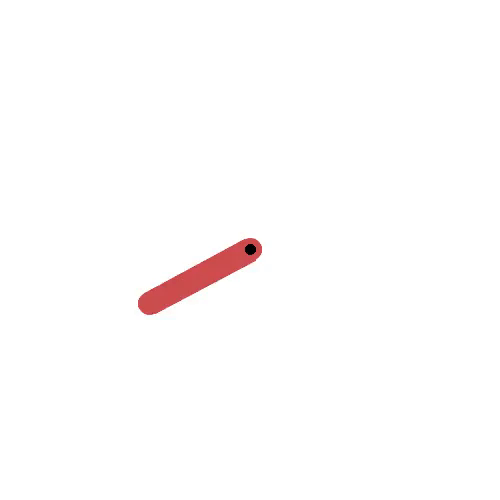

In [44]:
gym_simulation("Pendulum-v1", agent_sac)